# Multilevel Monte Carlo Path Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

# Add the path to the mlmc module to the python path
sys.path.append("../src")
from mlmc import MLMC
from model import BlackScholes
from contract import *

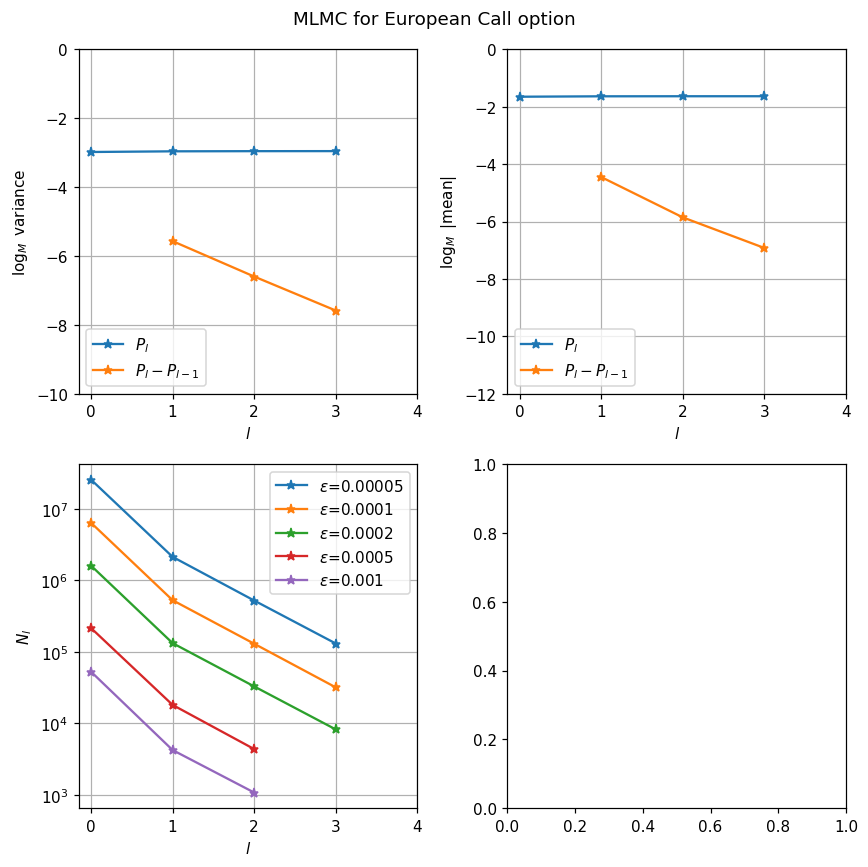

In [4]:
# Model parameters
interest_rate = 0.05
initial_value = 1.0
sigma = 0.2

model = BlackScholes(interest_rate, initial_value, sigma)

# Contract parameters
maturity = 1.0
strike = 1.0

contract = EuropeanCall(maturity, strike)
# contract = EuropeanPut(maturity, strike)
# contract = AsianCall(maturity, strike)
# contract = AsianPut(maturity, strike)

# MLMC parameters
max_level = 4
default_sample_count = 10_000
m = 4
# For reproducibility
rng = np.random.default_rng(seed=42)

mlmc = MLMC(max_level, m, default_sample_count, rng)

# As in the paper
target_errors = [0.00005, 0.0001, 0.0002, 0.0005, 0.001]

fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=110)
fig.suptitle(f"MLMC for {contract.type()} option")

for i, target_error in enumerate(target_errors):
    estimator, samples_per_level, final_level = mlmc.estimate(target_error, model, contract)

    levels = np.arange(final_level + 1)
    eps = f"{target_error:.5f}".rstrip("0")
    if i == 0:  # Creating the plor for the first estimator
        log_vars = np.log(np.cumsum(estimator["vars"][: len(levels)])) / np.log(m)
        axs[0, 0].plot(levels, log_vars, label=rf"$P_l$", marker="*")
        log_vars = np.log(estimator["vars"][1 : len(levels)]) / np.log(m)
        axs[0, 0].plot(levels[1:], log_vars, label=f"$P_l-P_{{l-1}}$", marker="*")

        log_means = np.log(np.abs(np.cumsum(estimator["means"][: len(levels)]))) / np.log(m)
        axs[0, 1].plot(levels, log_means, label=rf"$P_l$", marker="*")
        log_means = np.log(np.abs(estimator["means"][1 : len(levels)])) / np.log(m)
        axs[0, 1].plot(levels[1:], log_means, label=rf"$P_l-P_{{l-1}}$", marker="*")

    axs[1, 0].plot(levels, samples_per_level[: len(levels)], label=rf"$\varepsilon$={eps}", marker="*")

# Top left
axs[0, 0].set_xlabel("$l$")
axs[0, 0].set_ylabel("$\\log_M$ variance")
axs[0, 0].set_xticks(ticks=np.arange(max_level + 1))
axs[0, 0].set_yticks(ticks=np.arange(-10, 1, 2))
axs[0, 0].minorticks_off()
axs[0, 0].grid(which="major")
axs[0, 0].legend(loc="lower left")

# Top right
axs[0, 1].set_xlabel("$l$")
axs[0, 1].set_ylabel("$\\log_M$ |mean|")
axs[0, 1].set_xticks(ticks=np.arange(max_level + 1))
axs[0, 1].set_yticks(ticks=np.arange(-12, 1, 2))
axs[0, 1].minorticks_off()
axs[0, 1].grid(which="major")
axs[0, 1].legend(loc="lower left")

# Bottom left
axs[1, 0].set_xlabel("$l$")
axs[1, 0].set_ylabel("$N_l$")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xticks(ticks=np.arange(max_level + 1))
axs[1, 0].minorticks_off()
axs[1, 0].grid(which="major")
axs[1, 0].legend(loc="best")
fig.tight_layout()

plt.show()